# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"


# TensorFlow ≥2.0-preview is required
import tensorflow as tf
from tensorflow import keras
if tf.__version__ < "2.0":
    if keras.__version__ < "2.0":
        raise AssertionError("Keras version is too low")
    

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
print(tf.__version__)
print(keras.__version__)

2.2.0
2.3.0-tf


# Perceptrons

**Note**: we set `max_iter` and `tol` explicitly to avoid warnings about the fact that their default value will change in future versions of Scikit-Learn.

In [3]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int) # Iris Setosa?

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [4]:
y_pred

array([1])

In [5]:
per_clf.coef_

array([[-1.4, -2.2]])

Saving figure perceptron_iris_plot


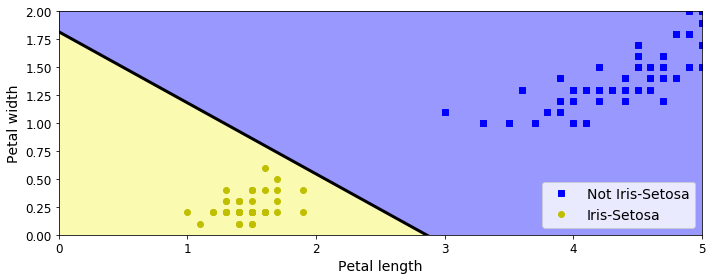

In [6]:
# y = alph0 + alph1*x1 + alph2*x2
# 0 = alph0 +  alph1*x1 + alph2*x2
# x2 = -(alp1/alph2)*x1 -(alpha0/alpha2)
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

# Activation functions

In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

Saving figure activation_functions_plot


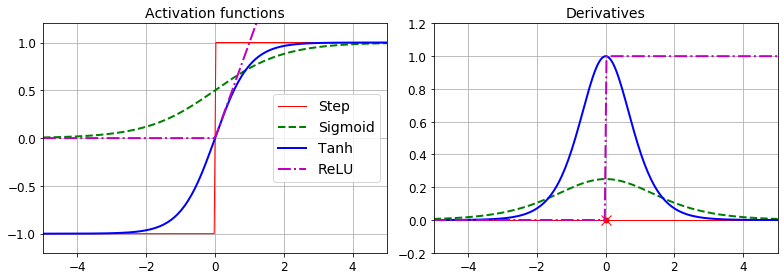

In [8]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

![Figure 10-6](https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure10_6.png?raw=true)

Above is XOR classification problem and an MLP that solves it in the book and let us implement it.

In [9]:
def heaviside(z):  # same as np.sign(), i.e., step function
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

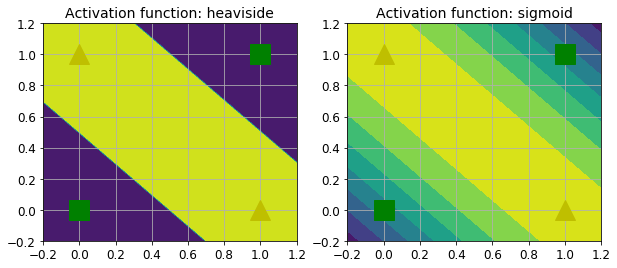

In [10]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

# Building an Image Classifier

First let's import `TensorFlow` and `Keras`

In [11]:
import tensorflow as tf
from tensorflow import keras

In [12]:
tf.__version__, keras.__version__

('2.2.0', '2.3.0-tf')

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [13]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [14]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [15]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [16]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

In [17]:
X_train.shape, X_train[0].shape

((55000, 28, 28), (28, 28))

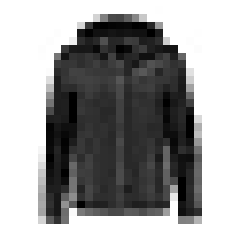

In [18]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [19]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

In [20]:
y_train.shape

(55000,)

In [21]:
classes, counts = np.unique(y_train, return_counts=True)

In [22]:
print("class counts")
for class_, count in zip(classes, counts):
    print(f'{class_:>3}{count:>8}')

class counts
  0    5543
  1    5444
  2    5496
  3    5499
  4    5512
  5    5507
  6    5507
  7    5488
  8    5510
  9    5494


Here are the corresponding class names:

In [23]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [24]:
class_names[y_train[0]]

'Coat'

In [25]:
## Extra
# converting y_train into names
import pandas as pd

class_dict = {}
for class_, name in zip(np.unique(y_train), class_names):
    class_dict[class_] = name

y_train_in_name = pd.Series(y_train).map(class_dict).values

y_train_in_name

array(['Coat', 'T-shirt/top', 'Sneaker', ..., 'Dress', 'T-shirt/top',
       'Sandal'], dtype=object)

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [26]:
X_valid.shape

(5000, 28, 28)

In [27]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

Saving figure fashion_mnist_plot


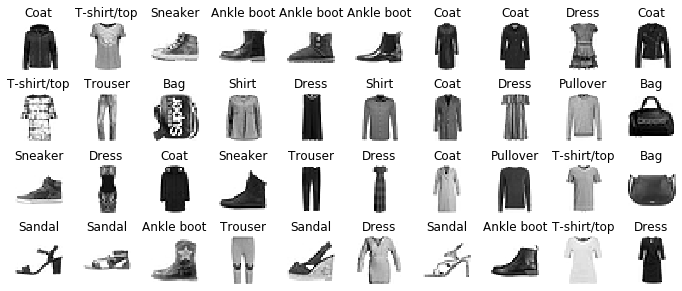

In [28]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

In [29]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [30]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [31]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [32]:
model.layers

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [34]:
#  W = (784 x 300), b = (300,)
300*784 + 500

235700

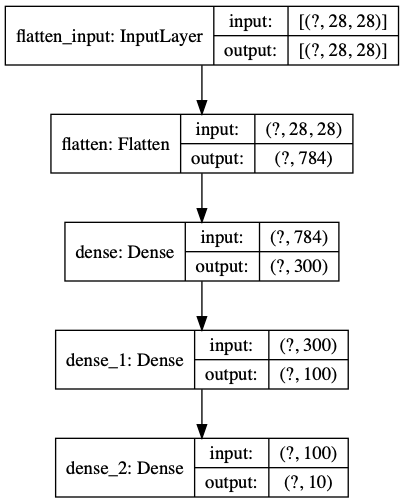

In [35]:
keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

In [36]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [37]:
model.get_layer(hidden1.name) is hidden1

True

In [38]:
hidden1

In [39]:
weights, biases = hidden1.get_weights()

In [40]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [41]:
weights.shape

(784, 300)

In [42]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [43]:
biases.shape

(300,)

In [44]:
hidden1.get_config()

{'name': 'dense',
 'trainable': True,
 'dtype': 'float32',
 'units': 300,
 'activation': 'relu',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [45]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

In [46]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.7237 - accuracy: 0.7644 - val_loss: 0.5207 - val_accuracy: 0.8234
Epoch 2/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4843 - accuracy: 0.8318 - val_loss: 0.4345 - val_accuracy: 0.8538
Epoch 3/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4392 - accuracy: 0.8455 - val_loss: 0.5334 - val_accuracy: 0.7982
Epoch 4/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4124 - accuracy: 0.8567 - val_loss: 0.3916 - val_accuracy: 0.8652
Epoch 5/30
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3939 - accuracy: 0.8619 - val_loss: 0.3750 - val_accuracy: 0.8686
Epoch 6/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3752 - accuracy: 0.8673 - val_loss: 0.3709 - val_accuracy: 0.8718
Epoch 7/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3633 - accuracy: 0.8715 - val_loss: 0.3618 - val_accuracy:

In [47]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [48]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [49]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Saving figure keras_learning_curves_plot


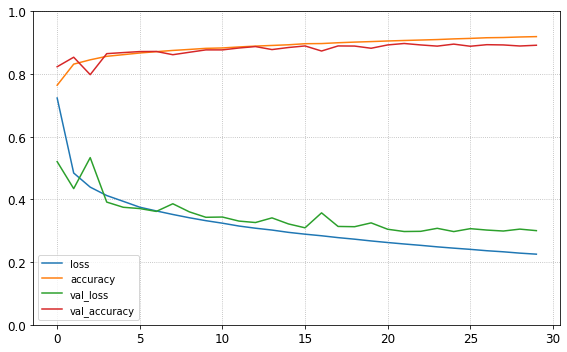

In [50]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.grid(linestyle=':')
save_fig("keras_learning_curves_plot")
plt.show()

> the validation error is computed at the `end` of each epoch, while the training error is computed using a running mean `during` each epoch
>> When plotting the training curve, it should be shifted by half an epoch to the left.


In [51]:
model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 3ms/step - loss: 0.3357 - accuracy: 0.8837


[0.3357059359550476, 0.8837000131607056]

In [52]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.03, 0.  , 0.96],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [53]:
# y_pred = model.predict_classes(X_new) #: depreciated
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

array([9, 2, 1])

In [54]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [55]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

In [56]:
X_new.shape

(3, 28, 28)

Saving figure fashion_mnist_images_plot


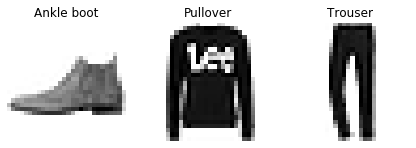

In [57]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

# Regression MLP

Let's load, split and scale the `California housing dataset` (the original one, not the modified one as in chapter 2):

In [58]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [59]:
np.random.seed(42)
tf.random.set_seed(42)

In [60]:
X_train.shape

(11610, 8)

In [61]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test, verbose=0)

X_new = X_test[:3]
y_pred = model.predict(X_new)
# mse_test

Epoch 1/20
363/363 [==============================] - 1s 3ms/step - loss: 1.6419 - val_loss: 0.8560
Epoch 2/20
363/363 [==============================] - 1s 3ms/step - loss: 0.7047 - val_loss: 0.6531
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 0.6345 - val_loss: 0.6099
Epoch 4/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5977 - val_loss: 0.5658
Epoch 5/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5706 - val_loss: 0.5355
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5472 - val_loss: 0.5173
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5288 - val_loss: 0.5081
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5130 - val_loss: 0.4799
Epoch 9/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4992 - val_loss: 0.4690
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4875 - val_loss: 0.4656

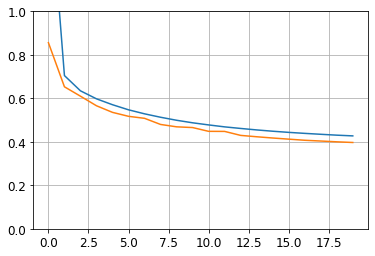

In [62]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [63]:
y_pred

array([[0.38856643],
       [1.6792021 ],
       [3.1022797 ]], dtype=float32)

# Functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.

![Figure 10-13](https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure10-13.png?raw=true)

Let’s build such a neural network to tackle the California housing problem:

In [64]:
np.random.seed(42)
tf.random.set_seed(42)

In [65]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
# As soon as it is created, notice that we call it like a function, passing it the input. 
# This is why this is called the Functional API
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
# create the output layer, with a single neuron and no activation function
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [66]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           930         dense_5[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_6[0][0]                

In [67]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
print("---------------------------------------------")
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.2611 - val_loss: 3.3940
Epoch 2/20
363/363 [==============================] - 1s 3ms/step - loss: 0.6580 - val_loss: 0.9360
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5878 - val_loss: 0.5649
Epoch 4/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5582 - val_loss: 0.5712
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5347 - val_loss: 0.5045
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5158 - val_loss: 0.4831
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5002 - val_loss: 0.4639
Epoch 8/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4876 - val_loss: 0.4638
Epoch 9/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4760 - val_loss: 0.4421
Epoch 10/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4659 - val_loss: 0.4313

In [68]:
y_pred

array([[0.47010726],
       [1.8735046 ],
       [3.379823  ]], dtype=float32)

What if you want to send different subsets of input features through the wide or deep paths? We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

![Figure 10-14](https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure10_14.png?raw=true)

In [69]:
keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

In [70]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [71]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
print("---------------------------------------------")
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.8145 - val_loss: 0.8072
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6771 - val_loss: 0.6658
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5979 - val_loss: 0.5687
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5584 - val_loss: 0.5296
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5334 - val_loss: 0.4993
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5120 - val_loss: 0.4811
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4970 - val_loss: 0.4696
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4843 - val_loss: 0.4496
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4730 - val_loss: 0.4404
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4644 - val_loss: 0.4315

In [72]:
y_pred

array([[0.30591205],
       [1.954067  ],
       [3.442611  ]], dtype=float32)

Another use case is as a regularization technique (i.e., a training constraint whose objective is to reduce overfitting and thus improve the model’s ability to generalize). For example, you may want to add some auxiliary outputs in a neural network architecture  to ensure that the underlying part of the network learns something useful on its own, without relying on the rest of the network.

Adding an auxiliary output for regularization:

![Figure 10-15](https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure10_15.png?raw=true)

In [73]:
keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

In [74]:
# Beware of input at each layer
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")

hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)

concat = keras.layers.concatenate([input_A, hidden2])

output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)

# specify that we have 2 inputs and 2 outputs
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

Each output will need its own loss function, so when we compile the model we should pass a list of losses (if we pass a single loss, Keras will assume that the same loss must be used for all outputs). By default, Keras will compute all these losses and __simply add them up to get the final loss used for training__. However, we __care much more about the main output__ than about the auxiliary output (as it is just used for regularization), so we want to give the main output’s loss a much __greater weight__. Fortunately, it is possible to set all the loss weights when compiling the model:

In [75]:
model.compile(loss=["mse", "mse"], 
              loss_weights=[0.9, 0.1], 
              optimizer=keras.optimizers.SGD(lr=1e-3))

In [76]:
# note that now we feed [y_valid, y_valid] at `validation_data`
history = model.fit([X_train_A, X_train_B], [y_train, y_train], 
                    epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 [==============================] - 1s 3ms/step - loss: 2.1365 - main_output_loss: 1.9196 - aux_output_loss: 4.0890 - val_loss: 1.6233 - val_main_output_loss: 0.8468 - val_aux_output_loss: 8.6117
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.8905 - main_output_loss: 0.6969 - aux_output_loss: 2.6326 - val_loss: 1.5163 - val_main_output_loss: 0.6836 - val_aux_output_loss: 9.0109
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7429 - main_output_loss: 0.6088 - aux_output_loss: 1.9499 - val_loss: 1.4639 - val_main_output_loss: 0.6229 - val_aux_output_loss: 9.0326
Epoch 4/20
363/363 [==============================] - 1s 3ms/step - loss: 0.6771 - main_output_loss: 0.5691 - aux_output_loss: 1.6485 - val_loss: 1.3388 - val_main_output_loss: 0.5481 - val_aux_output_loss: 8.4552
Epoch 5/20
363/363 [==============================] - 1s 3ms/step - loss: 0.6381 - main_output_loss: 0.5434 - aux_output_loss: 1.4911 - val_loss

When we evaluate the model, Keras will return the total loss, as well as all the individual losses:

In [77]:
total_loss, main_loss, aux_loss = model.evaluate([X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

162/162 [==============================] - 0s 1ms/step - loss: 0.4668 - main_output_loss: 0.4178 - aux_output_loss: 0.9082


In [78]:
total_loss, main_loss, aux_loss

(0.46683046221733093, 0.4177945852279663, 0.9081541299819946)

In [79]:
y_pred_main

array([[0.26762432],
       [1.980763  ],
       [3.3396287 ]], dtype=float32)

In [80]:
y_pred_aux

array([[0.9593649],
       [1.9240992],
       [2.5152814]], dtype=float32)

# The subclassing API

Some models involve loops, varying shapes, conditional branching, and other dynamic behaviors. For such cases, or simply if you prefer a more impera‐ tive programming style, the Subclassing API is for you.

Simply subclass the `Model` class, create the layers you need in the constructor, and use them to perform the computations you want in the `call()` method. For example, creating an instance of the following `WideAndDeepModel` class gives us an equivalent model to the one we just built with the Functional API. You can then compile it, evaluate it and use it to make predictions, exactly like we just did.

In [81]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

In [82]:
# same as before
model.compile(loss="mse", 
              loss_weights=[0.9, 0.1], 
              optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), 
                                                 (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Epoch 1/10
363/363 [==============================] - 1s 3ms/step - loss: 2.3298 - output_1_loss: 2.2186 - output_2_loss: 3.3304 - val_loss: 2.1435 - val_output_1_loss: 1.1581 - val_output_2_loss: 11.0117
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.9714 - output_1_loss: 0.8543 - output_2_loss: 2.0252 - val_loss: 1.7567 - val_output_1_loss: 0.8205 - val_output_2_loss: 10.1825
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.8268 - output_1_loss: 0.7289 - output_2_loss: 1.7082 - val_loss: 1.5664 - val_output_1_loss: 0.7913 - val_output_2_loss: 8.5419
Epoch 4/10
363/363 [==============================] - 1s 2ms/step - loss: 0.7636 - output_1_loss: 0.6764 - output_2_loss: 1.5477 - val_loss: 1.3088 - val_output_1_loss: 0.6549 - val_output_2_loss: 7.1933
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.7211 - output_1_loss: 0.6402 - output_2_loss: 1.4489 - val_loss: 1.1357 - val_output_1_loss: 0.5964 - val_

In [83]:
total_loss, main_loss, aux_loss = model.evaluate([X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

162/162 [==============================] - 0s 1ms/step - loss: 0.5841 - output_1_loss: 0.5188 - output_2_loss: 1.1722


In [84]:
total_loss, main_loss, aux_loss

(0.5841260552406311, 0.5187828540802002, 1.1722157001495361)

In [85]:
y_pred_main

array([[0.49889606],
       [1.4047124 ],
       [2.8973808 ]], dtype=float32)

In [86]:
y_pred_aux

array([[1.2453705],
       [1.6536491],
       [2.3804278]], dtype=float32)

# Saving and Restoring

In [87]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [88]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [89]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test, verbose = 0)
mse_test

Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4474 - val_loss: 0.4379

0.43822863698005676

In [90]:
model.save("my_keras_model.h5")

Saving a trained Keras model is as simple as it gets!

Keras will save both the model’s architecture (including every layer’s hyperparameters) and the value of all the model parameters for every layer (e.g., connection weights and biases), using the HDF5 format. It also saves the optimizer (including its hyperparameters and any state it may have).

 Loading the model is just as easy:

In [91]:
new_model = keras.models.load_model("my_keras_model.h5")

In [92]:
np.allclose(model.predict(X_new), model.predict(X_new))

True

This will work when using the `Sequential API` or the `Functional API`, but unfortunately __not__ when using `Model subclassing`. However, you can use `save_weights()` and `load_weights()` to at least save and restore the model parameters (but you will need to save and restore everything else yourself).

In [93]:
model.save_weights("my_keras_weights.ckpt")

In [94]:
model.load_weights("my_keras_weights.ckpt")

# Using Callbacks during Training

But what if training lasts several hours? This is quite common, especially when training on large datasets. In this case, you should not only save your model at the end of training, but also save checkpoints at regular intervals during training. But how can you tell the `fit()` method to save checkpoints? The answer is: using `callbacks`.

In [95]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [96]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

if you use a validation set during training, you can set `save_best_only=True` when creating the `ModelCheckpoin`t. In this case, it will only save your model when its performance on the validation set is the best so far. This way, you do not need to worry about training for too long and overfitting the training set: simply restore the last model saved after training, and this will be the best model on the validation set.

In [97]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])

print("-----------------------------------------")
model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 1s 1ms/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 1s 1ms/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4474 - val_loss: 0.4379

0.43822863698005676

In [98]:
keras.backend.clear_session()
model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test, verbose=0)
mse_test

0.43822863698005676

Another way to implement early stopping is to simply use the `EarlyStopping` callback. It will interrupt training when it measures no progress on the validation set for a number of epochs (defined by the patience argument), and it will optionally roll back to the best model. You can combine both callbacks to both save checkpoints of your model (in case your computer crashes), and actually interrupt training early when there is no more progress.

The number of epochs can be set to a large value since training will stop automatically when there is no more progress. Moreover, there is no need to restore the best model saved in this case since the `EarlyStopping` callback will keep track of the best weights and restore them for us at the end of training.

In [99]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test, verbose=0)

Epoch 1/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4393 - val_loss: 0.4110
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4315 - val_loss: 0.4266
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4259 - val_loss: 0.3996
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4201 - val_loss: 0.3939
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4154 - val_loss: 0.3889
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4111 - val_loss: 0.3866
Epoch 7/100
363/363 [==============================] - 1s 1ms/step - loss: 0.4074 - val_loss: 0.3860
Epoch 8/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4040 - val_loss: 0.3793
Epoch 9/100
363/363 [==============================] - 1s 1ms/step - loss: 0.4008 - val_loss: 0.3746
Epoch 10/100
363/363 [==============================] - 1s 1ms/step - loss: 0.3976 - val_lo

363/363 [==============================] - 0s 1ms/step - loss: 0.3324 - val_loss: 0.3274
Epoch 82/100
363/363 [==============================] - 1s 1ms/step - loss: 0.3320 - val_loss: 0.3167
Epoch 83/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3317 - val_loss: 0.3280
Epoch 84/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3312 - val_loss: 0.3634
Epoch 85/100
363/363 [==============================] - 1s 1ms/step - loss: 0.3310 - val_loss: 0.3176
Epoch 86/100
363/363 [==============================] - 1s 1ms/step - loss: 0.3308 - val_loss: 0.3156
Epoch 87/100
363/363 [==============================] - 1s 1ms/step - loss: 0.3305 - val_loss: 0.3529
Epoch 88/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3299 - val_loss: 0.3258
Epoch 89/100
363/363 [==============================] - 1s 1ms/step - loss: 0.3294 - val_loss: 0.3630
Epoch 90/100
363/363 [==============================] - 1s 1ms/step - loss: 0.3296 - val_loss: 

If you need extra control, you can easily write your own custom callbacks. For example, the following custom callback will display the ratio between the validation loss and the training loss during training (e.g., to detect overfitting):

In [100]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print(f'\nval/train: {logs["val_loss"] / logs["loss"]:.2f}')

In [101]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=3,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

Epoch 1/3
326/363 [=========================>....] - ETA: 0s - loss: 0.3292
val/train: 1.08
363/363 [==============================] - 0s 1ms/step - loss: 0.3302 - val_loss: 0.3556
Epoch 2/3
315/363 [=========================>....] - ETA: 0s - loss: 0.3271
val/train: 1.00
363/363 [==============================] - 0s 1ms/step - loss: 0.3301 - val_loss: 0.3304
Epoch 3/3
329/363 [==========================>...] - ETA: 0s - loss: 0.3340
val/train: 1.02
363/363 [==============================] - 0s 1ms/step - loss: 0.3296 - val_loss: 0.3347


You can implement:
- `on_train_begin()`, `on_train_end()`, `on_epoch_begin()`, `on_epoch_begin()`, `on_batch_end()` and `on_batch_end()` (called by `fit()`)
- `on_test_begin()`, `on_test_end()`, `on_test_batch_begin()`, or `on_test_batch_end()` (called by `evaluate()`), 
- `on_predict_begin()`, `on_pre dict_end()`, `on_predict_batch_begin()`, or `on_predict_batch_end()` (called by `predict()`)

# TensorBoard

`TensorBoard` is a great interactive visualization tool that you can use to view the learning curves during training, compare learning curves between multiple runs, visualize the computation graph, analyze training statistics, view images generated by your model, visualize complex multidimensional data projected down to 3D and automatically clustered for you, and more!

In [102]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [103]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./my_logs/run_2020_06_02-20_45_15'

In [104]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [105]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [106]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 1s 2ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/30
363/363 [==============================] - 1s 2ms/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/30
363/363 [==============================] - 1s 1ms/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/30
363/363 [==============================] - 1s 1ms/step - loss: 0.4474 - val_loss: 0.4379

To start the TensorBoard server, one option is to open a terminal, if needed activate the virtualenv where you installed TensorBoard, go to this notebook's directory, then type:

```bash
$ tensorboard --logdir=./my_logs --port=6006
```

You can then open your web browser to [localhost:6006](http://localhost:6006) and use TensorBoard. Once you are done, press Ctrl-C in the terminal window, this will shutdown the TensorBoard server.

Alternatively, you can load TensorBoard's Jupyter extension and run it like this:

In [107]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

ERROR: Failed to launch TensorBoard (exited with 255).
Contents of stderr:
E0602 20:45:36.901775 4606729664 program.py:311] TensorBoard could not bind to port 6006, it was already in use
ERROR: TensorBoard could not bind to port 6006, it was already in use

In [108]:
run_logdir2 = get_run_logdir()
run_logdir2

'./my_logs/run_2020_06_02-20_45_37'

In [109]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [110]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
# note that learning rate has changed from 0.001 to 0.05
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.05))

In [111]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5530 - val_loss: 302.8536
Epoch 2/30
363/363 [==============================] - 1s 1ms/step - loss: 5292745216.0000 - val_loss: 1.3230
Epoch 3/30
363/363 [==============================] - 1s 2ms/step - loss: 1.3411 - val_loss: 1.3176
Epoch 4/30
363/363 [==============================] - 1s 2ms/step - loss: 1.3423 - val_loss: 1.3261
Epoch 5/30
363/363 [==============================] - 1s 2ms/step - loss: 1.3423 - val_loss: 1.3154
Epoch 6/30
363/363 [==============================] - 1s 2ms/step - loss: 1.3431 - val_loss: 1.3203
Epoch 7/30
363/363 [==============================] - 1s 2ms/step - loss: 1.3425 - val_loss: 1.3149
Epoch 8/30
363/363 [==============================] - 1s 2ms/step - loss: 1.3433 - val_loss: 1.3157
Epoch 9/30
363/363 [==============================] - 1s 2ms/step - loss: 1.3435 - val_loss: 1.3150
Epoch 10/30
363/363 [==============================] - 1s 2ms/step - loss: 1.3423 - val_l

In [112]:
%reload_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

ERROR: Failed to launch TensorBoard (exited with 255).
Contents of stderr:
E0602 20:46:01.213960 4646436288 program.py:311] TensorBoard could not bind to port 6006, it was already in use
ERROR: TensorBoard could not bind to port 6006, it was already in use

In [113]:
!kill 27233

/bin/sh: line 0: kill: (27233) - No such process


Notice how TensorBoard now sees two runs, and you can compare the learning curves.

Check out the other available logging options:

In [114]:
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module tensorflow.python.keras.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, update_freq='epoch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



# Hyperparameter Tuning
The flexibility of neural networks is also one of their main drawbacks: there are many hyperparameters to tweak. Not only can you use any imaginable network architecture, but even in a simple MLP you can change the number of layers, the number of neurons per layer, the type of activation function to use in each layer, the weight initialization logic, and much more.

One option is to simply try __many combinations__ of hyperparameters and see which one works best on the validation set (or using `K-fold cross-validation`). For this, one approach is simply use `GridSearchCV` or `RandomizedSearchCV` to explore the hyperparameter space. For this, we need to __`wrap our Keras models in objects that mimic regular Scikit-Learn regressors`__. The first step is to create a function that will build and compile a Keras model, given a set of hyperparameters:

In [115]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [116]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [117]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [118]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
363/363 [==============================] - 1s 2ms/step - loss: 1.0896 - val_loss: 20.7721
Epoch 2/100
363/363 [==============================] - 1s 1ms/step - loss: 0.7606 - val_loss: 5.0266
Epoch 3/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5456 - val_loss: 0.5490
Epoch 4/100
363/363 [==============================] - 1s 1ms/step - loss: 0.4732 - val_loss: 0.4529
Epoch 5/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4503 - val_loss: 0.4188
Epoch 6/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4338 - val_loss: 0.4129
Epoch 7/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4241 - val_loss: 0.4004
Epoch 8/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4168 - val_loss: 0.3944
Epoch 9/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4108 - val_loss: 0.3961
Epoch 10/100
363/363 [==============================] - 1s 1ms/step - loss: 0.4060 - val_l

363/363 [==============================] - 0s 1ms/step - loss: 0.3383 - val_loss: 0.3432
Epoch 82/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3371 - val_loss: 0.3211
Epoch 83/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3367 - val_loss: 0.3342
Epoch 84/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3362 - val_loss: 0.4136
Epoch 85/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3369 - val_loss: 0.3285
Epoch 86/100
363/363 [==============================] - 1s 1ms/step - loss: 0.3359 - val_loss: 0.3440
Epoch 87/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3357 - val_loss: 0.3733
Epoch 88/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3355 - val_loss: 0.3188
Epoch 89/100
363/363 [==============================] - 1s 1ms/step - loss: 0.3346 - val_loss: 0.3492
Epoch 90/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3348 - val_loss: 

In [119]:
mse_test = keras_reg.score(X_test, y_test, )
# the greater the better rule in grid search, so sign is fliped in score. 
# -mse_test

162/162 [==============================] - 0s 1ms/step - loss: 0.3409


In [120]:
y_pred = keras_reg.predict(X_new)

y_pred

array([0.58884525, 1.5484407 , 4.1112185 ], dtype=float32)

In [121]:
dir(keras_reg)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_keras_api_names',
 '_keras_api_names_v1',
 'build_fn',
 'check_params',
 'filter_sk_params',
 'fit',
 'get_params',
 'model',
 'predict',
 'score',
 'set_params',
 'sk_params']

In [122]:
y_valid.shape, y_train.shape

((3870,), (11610,))

**Warning**: the following cell crashes at the end of training. This seems to be caused by [Keras issue #13586](https://github.com/keras-team/keras/issues/13586), which was triggered by a recent change in Scikit-Learn. [Pull Request #13598](https://github.com/keras-team/keras/pull/13598) seems to fix the issue, so this problem should be resolved soon.

In [124]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

fit_params = {
#              "epochs": 100,
             "validation_data": (X_valid, y_valid),}
#              "callbacks": [keras.callbacks.EarlyStopping(patience=10)]}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, **fit_params)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] learning_rate=0.00037192261022352417, n_hidden=3, n_neurons=80 ..


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


121/121 [==============================] - 0s 718us/step - loss: 1.8693
[CV]  learning_rate=0.00037192261022352417, n_hidden=3, n_neurons=80, total=   0.8s
[CV] learning_rate=0.00037192261022352417, n_hidden=3, n_neurons=80 ..


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


121/121 [==============================] - 0s 676us/step - loss: 2.0809
[CV]  learning_rate=0.00037192261022352417, n_hidden=3, n_neurons=80, total=   0.8s
[CV] learning_rate=0.00037192261022352417, n_hidden=3, n_neurons=80 ..
121/121 [==============================] - 0s 622us/step - loss: 2.2219
[CV]  learning_rate=0.00037192261022352417, n_hidden=3, n_neurons=80, total=   0.8s
[CV] learning_rate=0.0008763224455697141, n_hidden=1, n_neurons=47 ...
121/121 [==============================] - 0s 728us/step - loss: 1.5523
[CV]  learning_rate=0.0008763224455697141, n_hidden=1, n_neurons=47, total=   0.6s
[CV] learning_rate=0.0008763224455697141, n_hidden=1, n_neurons=47 ...
121/121 [==============================] - 0s 599us/step - loss: 1.3478
[CV]  learning_rate=0.0008763224455697141, n_hidden=1, n_neurons=47, total=   0.6s
[CV] learning_rate=0.0008763224455697141, n_hidden=1, n_neurons=47 ...
121/121 [==============================] - 0s 583us/step - loss: 1.1414
[CV]  learning_rate=0.

121/121 [==============================] - 0s 635us/step - loss: 0.6215
[CV]  learning_rate=0.0049786840924071745, n_hidden=3, n_neurons=47, total=   0.7s
[CV] learning_rate=0.0049786840924071745, n_hidden=3, n_neurons=47 ...
121/121 [==============================] - 0s 792us/step - loss: 0.5510
[CV]  learning_rate=0.0049786840924071745, n_hidden=3, n_neurons=47, total=   0.7s
[CV] learning_rate=0.0049786840924071745, n_hidden=3, n_neurons=47 ...
121/121 [==============================] - 0s 679us/step - loss: 0.5780
[CV]  learning_rate=0.0049786840924071745, n_hidden=3, n_neurons=47, total=   0.8s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   21.0s finished


RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fb0793a1b90>, as the constructor either does not set or modifies parameter learning_rate

In [125]:
rnd_search_cv.best_params_

{'learning_rate': 0.02298924804076755, 'n_hidden': 1, 'n_neurons': 9}

In [126]:
rnd_search_cv.best_score_

-0.49945985277493793

In [127]:
# rnd_search_cv.best_estimator_

In [128]:
# # rnd_search_cv.score(X_test, y_test)

In [129]:
# model = rnd_search_cv.best_estimator_.model
# model

In [130]:
# model.evaluate(X_test, y_test, verbose=0) 

# Exercise solutions

## 10.

*Exercise: Train a deep MLP on the MNIST dataset (you can load it using `keras.datasets.mnist.load_data()`. See if you can get over 98% precision. Try searching for the optimal learning rate by using the approach presented in this chapter (i.e., by growing the learning rate exponentially, plotting the loss, and finding the point where the loss shoots up). Try adding all the bells and whistles—save checkpoints, use early stopping, and plot learning curves using TensorBoard.*

Let's load the dataset:

In [131]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

Just like for the Fashion MNIST dataset, the MNIST training set containns 60,000 grayscale images, each 28 x 28 pixels:

In [132]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is also represented as a byte (0 to 255):

In [133]:
type(X_train_full)

numpy.ndarray

In [134]:
X_train_full.dtype

dtype('uint8')

In [135]:
X_train_full.min(), X_train_full.max()

(0, 255)

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255, just like we did for Fashion MNIST:

In [136]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Let's plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

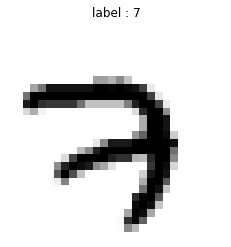

In [137]:
plt.imshow(X_train[0], cmap="binary")
plt.title(f'label : {y_train[0]}')
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9. Conveniently, the class IDs correspond to the digits represented in the images, so we don't need a `class_names` array:

In [138]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [139]:
X_train.shape, X_valid.shape, X_test.shape

((55000, 28, 28), (5000, 28, 28), (10000, 28, 28))

Let's take a look at a sample of the images in the dataset:

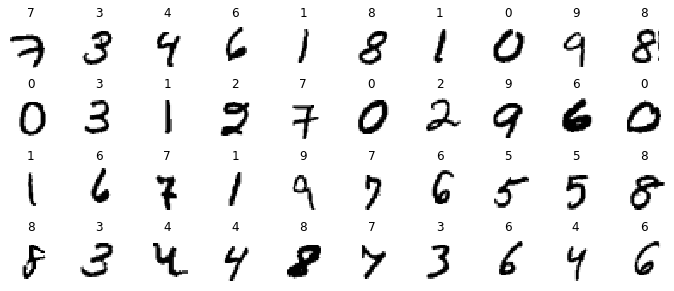

In [140]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Let's build a simple dense network and find the optimal learning rate. We will need a callback to grow the learning rate at each iteration. It will also record the learning rate and the loss at each iteration:

In [141]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
        
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, 
                    self.model.optimizer.lr*self.factor)

In [142]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [143]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(200, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration:

In [144]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

Now let's train the model for just 1 epoch:

In [145]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    batch_size=32, # default
                    steps_per_epoch=X_train.shape[0]//32, # default
                    callbacks=[expon_lr])

1718/1718 [==============================] - 3s 2ms/step - loss: nan - accuracy: 0.5938 - val_loss: nan - val_accuracy: 0.0958


We can now plot the loss as a functionof the learning rate:

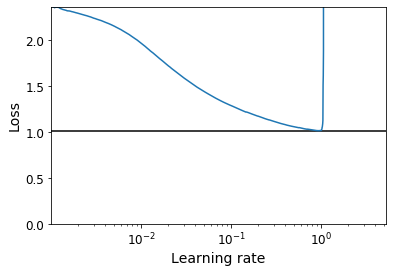

In [146]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.xlabel("Learning rate")
plt.ylabel("Loss");

The loss starts shooting back up violently around 8e-1, but since the curve is smooth before abrubt shoot-up, let's try using 2.5e-1 as our learning rate:

In [147]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [148]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(200, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [149]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=2.5e-1),
              metrics=["accuracy"])

In [150]:
run_index = 1 # increment this at every run
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))
run_logdir

'./my_mnist_logs/run_001'

In [151]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, checkpoint_cb, tensorboard_cb])

Epoch 1/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2296 - accuracy: 0.9277 - val_loss: 0.0951 - val_accuracy: 0.9704
Epoch 2/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0895 - accuracy: 0.9720 - val_loss: 0.1137 - val_accuracy: 0.9658
Epoch 3/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0608 - accuracy: 0.9810 - val_loss: 0.0691 - val_accuracy: 0.9794
Epoch 4/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0427 - accuracy: 0.9862 - val_loss: 0.0691 - val_accuracy: 0.9790
Epoch 5/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0308 - accuracy: 0.9902 - val_loss: 0.0580 - val_accuracy: 0.9860
Epoch 6/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0240 - accuracy: 0.9922 - val_loss: 0.0651 - val_accuracy: 0.9810
Epoch 7/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0195 - accuracy: 0.9936 - val_loss: 0.0779 - val_ac

In [152]:
model = keras.models.load_model("my_mnist_model.h5") # rollback to best model
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 859us/step - loss: 0.0649 - accuracy: 0.9815


[0.06490381807088852, 0.9815000295639038]

We got over 98% accuracy. Finally, let's look at the learning curves using TensorBoard:

In [153]:
%tensorboard --logdir=./my_mnist_logs --port=6006

Reusing TensorBoard on port 6006 (pid 99890), started 0:28:30 ago. (Use '!kill 99890' to kill it.)